In [2]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import copy as cp
import pandas as pd
import countryinfo
import geopandas as gpd
from timeit import default_timer as timer # try to measure time
from climada.engine import Impact
from random import sample


In [3]:
##function definition
from functions import *
from climada_functions import *
from constants import * 
idx = pd.IndexSlice

In [4]:
SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 24
#plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
#plt.rc('axes', titlesize=MEDIUM_SIZE) 
#plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
#plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
#plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
#plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
#plt.rc('figure', titlesize=BIGGER_SIZE)  #
#plt.rcParams['figure.figsize'] = [8.0, 8.0]
plt.rcParams['savefig.dpi'] = 300
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
#plt.rcParams["fig.titleweight"] = 'bold'
plt.rcParams["axes.titleweight"] = 'bold'
plt.rcParams["legend.fontsize"] = 20
plt.rcParams["legend.title_fontsize"] = 18

In [5]:
plt.rcParams.keys()

KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.formatter.useoffset': True,
          'axes.grid': False,
          'axes.grid.axis': 'both',
          'axes.gri

In [6]:
## select data
#select variable (cmip6 naming)
selvar = 'sfcWindmax'
pathinvar = pathcmip6+'sfcWindmax/'

#preprocessing 
gst_fact = 1.67
qt = 0.98
cut=5E5
min_lat=30
max_lat=75
min_lon=-30
max_lon=30

##climada constants
haz_type = 'WS'
haz_id = 1

## naming
#name base (meteo) variable
metvar = [cmip6vars[selvar]]
spaceres = ["br_rg"] #base resolution regridded
timeres = ["day"]
domain = ["EU"]
season = ["winE"]
scen = ["allscens"]
sep = "_"
lst_bn = metvar+spaceres+timeres+domain+season
basenamemet = sep.join(lst_bn)

#preproc field
processings = ["qt"+str(qt)[-2:]+"pst","cutarea"+format(cut,'.0E').replace("+0",''),"gst1-67"]
basenamemet_proc = make_fn(processings,basenamemet)



In [ ]:
reglist2

In [5]:
scenlist

['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585']

# ANOVA

## ANOVA with impf uncertainty

In [7]:
#select simulation

impflist = ['Cubic excess-over-threshold','Emanuel 2011', 'Schwierz 2010']
impf_shtlist = [impf_sht_names[impf] for impf in impflist]
caltype = 'AAI_EMDAT_100mn'
pp_func_dic = pp_func_dic_diff
metrics = np.arange(1,16).tolist()
modlist = modlist_allscen
selreg = reglist3

In [9]:
#get data
nmems = 3
nscens = len(scenlist)
nmets = len(metrics)
#initiate df
nmem_idx = range(nmems)

col_idx = pd.MultiIndex.from_product([metrics,scenlist], names=["metric","scenario"])
row_idx = pd.MultiIndex.from_product([modlist,nmem_idx,impf_shtlist],names=["model","member","impf"])

row_idxtv = pd.MultiIndex.from_product([modlist,nmem_idx,impf_shtlist],names=["model","member","impf"])
tot_value_dict = {}
reg_dict = {}

for reg in selreg:
    stoc_df = pd.DataFrame(columns=col_idx,index=row_idx)
    stoc_df.sort_index(inplace=True)
    stoc_df.sort_index(inplace=True,axis=1)
    tot_val_df = pd.DataFrame(columns=scenlist,index=row_idxtv)
    tot_val_df.sort_index(inplace=True)
    tot_val_df.sort_index(inplace=True,axis=1)
    for modname in modlist:
        for scen in scenlist:
            for imem in range(nmems):
                for impf in impflist:
                    comp_metrics = metrics.copy()
                    impf_namesht = impf_sht_names[impf]
                    #get pp_func
                    pp_funcname = str(pp_func_dic[impf]).split(" ")[1]
                    #make file names
                    impfn= make_fn(['imp','nmem'+str(imem),reg,scen,modname,impf_namesht,caltype,pp_funcname],basenamemet_proc,filetype='.csv')
                    imp = Impact()
                    imp = imp.from_csv(pathimp+"impact csv/regional/memsep/"+reg+"/"+scen+"/"+impfn)
                    
                    if 'aai_agg' in metrics:
                        stoc_df.loc[(modname,imem,impf_namesht),('aai_agg',scen)] = imp.aai_agg
                        comp_metrics.remove('aai_agg')
                    stoc_df.loc[idx[modname,imem,impf_namesht],idx[comp_metrics,scen]] = imp.calc_freq_curve(return_per=comp_metrics).impact
                    tot_val_df.loc[idx[modname,imem,impf_namesht],scen] = imp.tot_value
        
    
    stoc_df = stoc_df.astype(np.float64)
    reg_dict[reg] = stoc_df
    tot_val_df = tot_val_df.astype(np.float64)
    tot_value_dict[reg] = tot_val_df.mean().mean()


In [11]:
#total value over the whole domain:
tot_value_domain = np.sum([totval for totval in tot_value_dict.values()])

In [76]:
## ANOVA future

norm_exp = False #normalize by the total explained variance
norm_tot = True # normalize by the total variance
norm_tot_val = False # normalize each region by its total affected value
mk_std = False #take the square root to have std instead of variance
ms_interaction = True
mi_interaction = True
rem_impf = None
unc_idx = ['Stochastic',"Scenario","Model","Impact function"]
if ms_interaction:
    unc_idx.append('Model-scenario interaction')
    
if mi_interaction:
    unc_idx.append('Model-impf. interaction')

unc_df_fut = pd.DataFrame(columns=metrics,index=unc_idx)
nregs = len(selreg)
res_reg_list = []
for i, reg in enumerate(reg_dict.keys()):
    reg_df = reg_dict[reg]
    unc_df_fut = pd.DataFrame(columns=metrics,index=unc_idx)
    
    for metric in metrics:
        df = reg_df[metric].copy().drop("historical",axis=1)
        if rem_impf:
            df = df.drop(rem_impf,axis=0,level=2)
            
        if norm_tot_val:
            tot_val_reg = tot_value_dict[reg]
            df = df/tot_val_reg
            ylab = 'Uncertainty contribution by total exposed value (USD/10E9 USD)'
            
        mod_mean = df.groupby(level="model").mean().mean(axis=1)
        impf_mean = df.groupby(level="impf").mean().mean(axis=1)
        scen_mean = df.mean()
        mod_scen_mean = df.groupby(level="model").mean()
        mod_impf_mean = df.groupby(level=["model","impf"]).mean().mean(axis=1)
        mod_scen_impf_mean = df.groupby(level=["model","impf"]).mean()
        nscen = len(scen_mean)
        nreal = nmems
        nmod = len(mod_mean)
        nimpf = len(impf_mean)
        ens_mean = df.mean().mean()
        #internal variabilty    
        intvar = 1/(nscen*nreal*nmod*nimpf)*np.sum(np.sum(np.sum((df.sub(mod_scen_impf_mean,axis=0))**2)))
        
        #scenario-inde model uncertainty
        mod_ind_var = 1/nmod*np.sum((mod_mean-ens_mean)**2)
        
        #scenario uncertainty
        scen_var = 1/nscen*np.sum((scen_mean-ens_mean)**2)
        
        #model-scenario interaction uncertainty
        modscen_int = 1/(nscen*nmod)*np.sum(np.sum((mod_scen_mean.add(ens_mean).sub(mod_mean,axis=0).sub(scen_mean,axis=1))**2))
        
        #impf uncertainty
        impf_ind_var = 1/nimpf*np.sum((impf_mean-ens_mean)**2)
        
        #model-impf interaction uncertainty
        modimpf_int = 1/(nmod*nimpf)*np.sum(np.sum((mod_impf_mean.add(ens_mean).sub(mod_mean,axis=0).sub(impf_mean,axis=0))**2))
        
        if mk_std:
            unc_df_fut.loc['Stochastic',metric] = np.sqrt(intvar)
            unc_df_fut.loc['Model',metric] = np.sqrt(mod_ind_var)
            unc_df_fut.loc['Scenario',metric] = np.sqrt(scen_var)
            unc_df_fut.loc["Impact function",metric] = np.sqrt(impf_ind_var)
        else:
            unc_df_fut.loc['Stochastic',metric] = intvar
            unc_df_fut.loc['Model',metric] = mod_ind_var
            unc_df_fut.loc['Scenario',metric] = scen_var
            unc_df_fut.loc["Impact function",metric] = impf_ind_var
        
        exp_unc = intvar + mod_ind_var + scen_var + impf_ind_var
        if ms_interaction:
            exp_unc = exp_unc + modscen_int
            if mk_std:
                unc_df_fut.loc['Model-scenario interaction',metric] = np.sqrt(modscen_int)
            else:
                unc_df_fut.loc['Model-scenario interaction',metric] = modscen_int
        if mi_interaction:
            exp_unc = exp_unc + modimpf_int
            if mk_std:
                unc_df_fut.loc['Model-impf. interaction',metric] = np.sqrt(modimpf_int)
            else:
                unc_df_fut.loc['Model-impf. interaction',metric] = modimpf_int
        
        #or tot_unc
        tot_unc = np.sum(np.sum((df-ens_mean)**2))/(nscen*nmod*nreal*nimpf)
        if mk_std:
            tot_unc = np.sqrt(tot_unc)
            exp_unc = np.sqrt(exp_unc)
        
        if norm_exp:
            unc_df_fut[metric] = (100/exp_unc)*unc_df_fut[metric]
            ylab = 'Uncertainty contribution (%)'
            
        if norm_tot:
            unc_df_fut[metric] = (100/tot_unc)*unc_df_fut[metric]
            ylab = 'Uncertainty contribution (%)'
        print("Explained variance (%):"+format(100*exp_unc/tot_unc,'.3'))
    
    
    
    res_reg_list.append(unc_df_fut)
unc_df_fut_allreg = pd.concat(res_reg_list,keys=selreg,axis=1)
    
unc_df_fut_allreg = unc_df_fut_allreg.astype(np.float64)

Explained variance (%):95.8
Explained variance (%):99.1
Explained variance (%):99.1
Explained variance (%):98.7
Explained variance (%):97.8
Explained variance (%):97.6
Explained variance (%):96.4
Explained variance (%):95.8
Explained variance (%):95.5
Explained variance (%):95.6
Explained variance (%):95.6
Explained variance (%):95.1
Explained variance (%):94.5
Explained variance (%):93.9
Explained variance (%):93.4
Explained variance (%):92.9
Explained variance (%):94.2
Explained variance (%):99.0
Explained variance (%):98.6
Explained variance (%):97.1
Explained variance (%):96.0
Explained variance (%):96.1
Explained variance (%):93.8
Explained variance (%):93.5
Explained variance (%):92.4
Explained variance (%):91.2
Explained variance (%):90.5
Explained variance (%):90.2
Explained variance (%):89.9
Explained variance (%):89.7
Explained variance (%):89.5
Explained variance (%):89.4
Explained variance (%):98.1
Explained variance (%):99.5
Explained variance (%):99.2
Explained variance (

In [13]:
## ANOVA future, using bootstrapping

#ANOVA model
norm_exp = False #normalize by the total explained variance
norm_tot = True # normalize by the total variance
norm_tot_val = False # normalize each region by its total affected value
mk_std = False #take the square root to have std instead of variance
ms_interaction = True
mi_interaction = True
rem_impf = None
unc_idx = ['Stochastic',"Scenario","Model","Impact function"]
if ms_interaction:
    unc_idx.append('Model-scenario interaction')
    
if mi_interaction:
    unc_idx.append('Model-impf. interaction')

nunc = len(unc_idx)
nmetrics = len(metrics)
nregs = len(selreg)
res_reg_list = []

#bootstrapping
nreps = 1000
modlist = modlist_allscen
selscen =  ['ssp126', 'ssp245', 'ssp370', 'ssp585']
sub_sample_size = 3 #factor variable with the minimum nb of levels: impf and members
resarr = np.nan * np.ones(shape=(nunc,nmetrics,nreps))
for i, reg in enumerate(reg_dict.keys()):
    reg_df = reg_dict[reg]
    for rep in range(nreps):
        unc_df_fut = pd.DataFrame(columns=metrics,index=unc_idx)
        subsel_mod = sample(modlist, k=sub_sample_size)
        subsel_scen = sample(selscen, k=sub_sample_size)

        for metric in metrics:
            df = reg_df.loc[subsel_mod][metric][subsel_scen].copy()
            if rem_impf:
                df = df.drop(rem_impf,axis=0,level=2)
                
            if norm_tot_val:
                tot_val_reg = tot_value_dict[reg]
                df = df/tot_val_reg
                ylab = 'Uncertainty contribution by total exposed value (10E-9 USD/USD)'
                
            mod_mean = df.groupby(level="model").mean().mean(axis=1)
            impf_mean = df.groupby(level="impf").mean().mean(axis=1)
            scen_mean = df.mean()
            mod_scen_mean = df.groupby(level="model").mean()
            mod_impf_mean = df.groupby(level=["model","impf"]).mean().mean(axis=1)
            mod_scen_impf_mean = df.groupby(level=["model","impf"]).mean()
            nscen = len(scen_mean)
            nreal = nmems
            nmod = len(mod_mean)
            nimpf = len(impf_mean)
            ens_mean = df.mean().mean()
            #internal variabilty    
            intvar = 1/(nscen*nreal*nmod*nimpf)*np.sum(np.sum(np.sum((df.sub(mod_scen_impf_mean,axis=0))**2)))
            
            #scenario-inde model uncertainty
            mod_ind_var = 1/nmod*np.sum((mod_mean-ens_mean)**2)
            
            #scenario uncertainty
            scen_var = 1/nscen*np.sum((scen_mean-ens_mean)**2)
            
            #model-scenario interaction uncertainty
            modscen_int = 1/(nscen*nmod)*np.sum(np.sum((mod_scen_mean.add(ens_mean).sub(mod_mean,axis=0).sub(scen_mean,axis=1))**2))
            
            #impf uncertainty
            impf_ind_var = 1/nimpf*np.sum((impf_mean-ens_mean)**2)
            
            #model-impf interaction uncertainty
            modimpf_int = 1/(nmod*nimpf)*np.sum(np.sum((mod_impf_mean.add(ens_mean).sub(mod_mean,axis=0).sub(impf_mean,axis=0))**2))
            
            if mk_std:
                unc_df_fut.loc['Stochastic',metric] = np.sqrt(intvar)
                unc_df_fut.loc['Model',metric] = np.sqrt(mod_ind_var)
                unc_df_fut.loc['Scenario',metric] = np.sqrt(scen_var)
                unc_df_fut.loc["Impact function",metric] = np.sqrt(impf_ind_var)
            else:
                unc_df_fut.loc['Stochastic',metric] = intvar
                unc_df_fut.loc['Model',metric] = mod_ind_var
                unc_df_fut.loc['Scenario',metric] = scen_var
                unc_df_fut.loc["Impact function",metric] = impf_ind_var
            
            exp_unc = intvar + mod_ind_var + scen_var + impf_ind_var
            if ms_interaction:
                exp_unc = exp_unc + modscen_int
                if mk_std:
                    unc_df_fut.loc['Model-scenario interaction',metric] = np.sqrt(modscen_int)
                else:
                    unc_df_fut.loc['Model-scenario interaction',metric] = modscen_int
            if mi_interaction:
                exp_unc = exp_unc + modimpf_int
                if mk_std:
                    unc_df_fut.loc['Model-impf. interaction',metric] = np.sqrt(modimpf_int)
                else:
                    unc_df_fut.loc['Model-impf. interaction',metric] = modimpf_int
            
            #or tot_unc
            tot_unc = np.sum(np.sum((df-ens_mean)**2))/(nscen*nmod*nreal*nimpf)
            if mk_std:
                tot_unc = np.sqrt(tot_unc)
                exp_unc = np.sqrt(exp_unc)
            
            if norm_exp:
                unc_df_fut[metric] = (100/exp_unc)*unc_df_fut[metric]
                ylab = 'Uncertainty contribution (%)'
                
            if norm_tot:
                unc_df_fut[metric] = (100/tot_unc)*unc_df_fut[metric]
                ylab = 'Uncertainty contribution (%)'
            #print("Explained variance (%):"+format(100*exp_unc/tot_unc,'.3'))
    
        unc_df_fut = unc_df_fut.astype(np.float64)
        resarr[:,:,rep] = unc_df_fut.values
    unc_df_fut_all = pd.DataFrame(resarr.mean(axis=2),index=unc_idx,columns=metrics)
    res_reg_list.append(unc_df_fut_all)

unc_df_fut_allreg = pd.concat(res_reg_list,keys=selreg,axis=1,names=["region","metric"])

In [185]:
drop_cubeot = (unc_df_fut_allreg2-unc_df_fut_allreg)/unc_df_fut_allreg
drop_cubeot.mean(axis=1)

Stochastic                   -0.117138
Scenario                      0.103358
Model                         0.313530
Impact function              -0.143975
Model-scenario interaction    0.094116
Model-impf. interaction      -0.309548
dtype: float64

In [15]:
#plot selecting 1 metric, 1 column per region
selmet = 5

#plotting params
saving = True
log_trans = False
sharefig = True #share one figure for different axis to combine different plots
ifig = 1
savename = 'rel_unc_part_reg_ms_inter_rp1_rp5.png'

titles = ['a) Uncertainty partitioning for one-year RPIs, by regions', 'b) Uncertainty partitioning for five-year RPIs, by regions']

#normalize data or take log
if norm_tot_val:
    unc_df_fut_allreg = unc_df_fut_allreg*1E9 #x1E9 to get loss event by for 1 bn USD of exposed value
idx = pd.IndexSlice
plot_df = unc_df_fut_allreg.loc[:,idx[:,selmet]]
if log_trans:
    plot_df = np.log10(plot_df)
plot_df.columns = plot_df.columns.droplevel(1)

#initiate plot
if sharefig:
    if ifig == 0:
        fig = plt.figure(figsize=(25,10))
        axs = fig.subplots(nrows=1,ncols=2,sharey=True,sharex=True)
    ax = axs[ifig]
else:
    fig = plt.figure(figsize=(10,7))
    axs = fig.subplots(nrows=1,ncols=1)
    ax = axs
    
plot_df.T.plot.bar(ax=ax,stacked=True,rot=0)
ax.set_ylabel(ylab,fontsize=18,fontweight='bold')
ax.set_xlabel('Regions',fontsize=18,fontweight='bold')
ax.set_title(titles[ifig],loc='left',fontsize=18,fontweight='bold')
#ax.set_title('Regional uncertainty partitioning for future '+str(selmet)+'yrs RP events')
#savename = 'abs_unc_part_reg_ms_inter_rp'+str(selmet)+'.png'
ax.legend(title='Uncertainty sources',loc='center left',fontsize=18)#loc='center left'
if saving:
    fig.savefig(pathfig+'/Uncertainty/'+savename,transparent=False)

In [92]:
def style_10high(v, props=''):
    return props if v > 10 else None
plot_df.index.name = 'Uncertainty partitioning per region (%)'
s2 = plot_df.style.applymap(style_10high, props='color:red;')
s2.format('{:.2f}')

,BI,IP,FR,ME,MD,SC,EA
Uncertainty partitioning per region (%),,,,,,,
Stochastic,39.66,41.65,42.58,44.28,36.72,42.65,31.61
Scenario,4.89,4.93,9.67,5.59,4.05,2.79,5.08
Model,24.18,17.06,22.70,29.06,21.09,26.14,25.28
Impact function,15.26,11.26,5.11,7.08,14.32,8.24,23.21
Model-scenario interaction,7.33,10.64,10.05,5.97,4.75,5.37,4.13
Model-impf. interaction,4.09,7.97,5.68,5.61,11.62,10.92,8.28


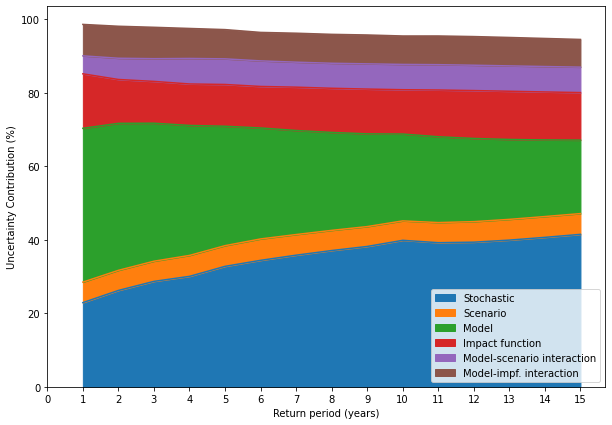

In [123]:
#unc vs rp plots,regional average plots
#select data
unc_df_fut_regavg = unc_df_fut_allreg.groupby("metric",axis=1).mean()
unc_df_fut_ss = unc_df_fut_regavg.T.loc[slice(None)]
unc_df_fut_ss_log = np.log10(unc_df_fut_ss)
unc_df_fut.index.name = 'Uncertainty sources'

#plotting param
saving = False
savename = 'rel_unc_vs_rp_reg_bs_fut_ms_mi_inter'+basenameimp+'.png'

#initiate plot
fig = plt.figure(figsize=(10,7))
ax = fig.subplots(nrows=1,ncols=1)
unc_df_fut_ss.plot.area(ax=ax)
ax.set_ylabel('Uncertainty Contribution (%)')
ax.set_xlabel('Return period (years)')
ax.set_xticks(range(0,16))
#ax.set_title('Uncertainty partitioning for Europe, future')
#plt.legend(loc='center left')
if saving:
    plt.savefig(pathfig+'/Uncertainty/'+savename,transparent=False)

In [118]:
unc_df_fut_regavg

metric,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Stochastic,22.920027,26.234036,28.703605,30.065376,32.792092,34.429761,35.832412,37.095120,38.208410,39.879918,39.230000,39.373909,39.935623,40.685664,41.500177
Scenario,5.577190,5.472071,5.488778,5.699281,5.632660,5.823946,5.618757,5.491559,5.406586,5.286001,5.480080,5.591892,5.646628,5.663396,5.655800
Model,41.869575,40.023149,37.570883,35.388459,32.510312,30.211330,28.327527,26.666935,25.249511,23.644300,23.364554,22.641529,21.758534,20.857555,19.999510
Impact function,14.840575,11.936328,11.379490,11.292911,11.371298,11.301548,11.798055,12.019683,12.192910,12.069080,12.728212,13.038942,13.119792,13.067893,12.945011
Model-scenario interaction,4.890133,5.781945,6.183426,6.943283,6.976492,6.963602,6.802353,6.811060,6.865622,6.890239,6.896708,6.901154,6.907982,6.916430,6.925617
Model-impf. interaction,8.563011,8.710463,8.550046,8.169947,7.965737,7.754368,7.885509,7.871232,7.860999,7.739912,7.815195,7.802697,7.737487,7.645683,7.543282


## ANOVA Past

In [1]:
## ANOVA past

normalized = True
ms_interaction = True
mi_interaction = True
unc_idx = ['Stochastic',"Scenario","Model","Impact function"]
if ms_interaction:
    unc_idx.append('Model-scenario interaction')
    
if mi_interaction:
    unc_idx.append('Model-impf. interaction')

unc_df_past = pd.DataFrame(columns=metrics,index=unc_idx)
nregs = len(reglist)
res_reg_list = []
for i, reg in enumerate(reg_dict.keys()):
    reg_df = reg_dict[reg]
    unc_df_past = pd.DataFrame(columns=metrics,index=unc_idx)
    for metric in metrics:
        df = reg_df[metric]["past"].copy()
        mod_mean = df.groupby(level="model").mean().mean(axis=1)
        impf_mean = df.groupby(level="impf").mean().mean(axis=1)
        scen_mean = df.mean()
        mod_scen_mean = df.groupby(level="model").mean()
        mod_impf_mean = df.groupby(level=["model","impf"]).mean().mean(axis=1)
        mod_scen_impf_mean = df.groupby(level=["model","impf"]).mean()
        nscen = len(scen_mean)
        nreal = nmems
        nmod = len(mod_mean)
        nimpf = len(impf_mean)
        ens_mean = df.mean().mean()
        #internal variabilty    
        intvar = 1/(nscen*nreal*nmod*nimpf)*np.sum(np.sum(np.sum((df.sub(mod_scen_impf_mean,axis=0))**2)))
        
        #scenario-inde model uncertainty
        mod_ind_var = 1/nmod*np.sum((mod_mean-ens_mean)**2)
        
        #scenario uncertainty
        scen_var = 1/nscen*np.sum((scen_mean-ens_mean)**2)
        
        #model-scenario interaction uncertainty
        modscen_int = 1/(nscen*nmod)*np.sum(np.sum((mod_scen_mean.add(ens_mean).sub(mod_mean,axis=0).sub(scen_mean,axis=1))**2))
        
        #impf uncertainty
        impf_ind_var = 1/nimpf*np.sum((impf_mean-ens_mean)**2)
        
        #model-impf interaction uncertainty
        modimpf_int = 1/(nmod*nimpf)*np.sum(np.sum((mod_impf_mean.add(ens_mean).sub(mod_mean,axis=0).sub(impf_mean,axis=0))**2))
        
        unc_df_past.loc['Stochastic',metric] = intvar
        unc_df_past.loc['Model',metric] = mod_ind_var
        unc_df_past.loc['Scenario',metric] = scen_var
        unc_df_past.loc["Impact function",metric] = impf_ind_var
        
        tot_unc = intvar + mod_ind_var + scen_var + impf_ind_var
        if ms_interaction:
            tot_unc = tot_unc + modscen_int 
            unc_df_past.loc['Model-scenario interaction',metric] = modscen_int
        if mi_interaction:
            tot_unc = tot_unc + modimpf_int
            unc_df_past.loc['Model-impf. interaction',metric] = modimpf_int
        
        if normalized:
            unc_df_past[metric] = (100/tot_unc)*unc_df_past[metric]
        #or tot_unc
        #tot_unc = np.sum(np.sum((df-ens_mean)**2))
    res_reg_list.append(unc_df_past)
unc_df_past_allreg = pd.concat(res_reg_list,keys=reglist,axis=1)
    
        

NameError: name 'pd' is not defined

In [40]:
unc_df_past_allreg

UK                                   \
                              aai_agg          1         10         15   
Stochastic                   2.917939   1.791254  11.359314   8.435981   
Scenario                          0.0        0.0        0.0        0.0   
Model                        18.05424  18.222089  18.173451  18.235753   
Impact function             43.041909  43.401712  36.236886   37.81704   
Model-scenario interaction        0.0        0.0        0.0        0.0   
Model-impf. interaction     35.985912  36.584945   34.23035  35.511225   

                                  WEU                                   \
                              aai_agg          1         10         15   
Stochastic                   0.425603   0.486884   7.496878   9.767291   
Scenario                          0.0        0.0        0.0        0.0   
Model                        22.40073  23.353524  20.676544  21.865379   
Impact function             34.982184  33.835482  34.466078  30.491264   
Model-scenario interaction        0.0        0.0        0.0        0.0   
Model-impf. interaction     42.191482   42.32411    37.3605  37.876066   

                                  SEU                                   \
                              aai_agg          1         10         15   
Stochastic                   1.897299   1.966395  15.386309  13.265214   
Scenario                          0.0        0.0        0.0        0.0   
Model                       21.407137   21.55622  20.895475  20.807665   
Impact function              37.99012  37.399372   30.37736  31.175398   
Model-scenario interaction        0.0        0.0        0.0        0.0   
Model-impf. interaction     38.705444  39.078013  33.340856  34.751723   

                                  EEU                                   \
                              aai_agg          1         10         15   
Stochastic                   0.976826   2.354739   3.908674  11.086818   
Scenario                          0.0        0.0        0.0        0.0   
Model                       20.899896   20.30187  21.417461  21.554477   
Impact function             39.988318   39.40531  37.999355  33.415111   
Model-scenario interaction        0.0        0.0        0.0        0.0   
Model-impf. interaction      38.13496  37.938082   36.67451  33.943595   

                                  NOR                                   
                              aai_agg          1         10         15  
Stochastic                   0.962369   1.001552  14.569276  16.545604  
Scenario                          0.0        0.0        0.0        0.0  
Model                       23.255925  23.269789  23.274162    23.1796  
Impact function             35.081039  34.521809  27.875414  29.753253  
Model-scenario interaction        0.0        0.0        0.0        0.0  
Model-impf. interaction     40.700667   41.20685  34.281148  30.521543

In [39]:
unc_df_past.columns = ['AAI',str(metrics[1])+'-yrs impact']
ax = unc_df_past.T.plot.bar(stacked=True,rot=0)
ax.set_ylabel('Uncertainty Contribution (%)')
ax.set_xlabel('Metrics')
ax.set_title('Uncertainty partitioning for Europe, past')
plt.legend(loc='center left')
#plt.savefig(savefigpath+'unc_part_EU.png',transparent=False)

ValueError: Length mismatch: Expected axis has 4 elements, new values have 2 elements

In [15]:
def style_10high(v, props=''):
    return props if v > 10 else None
unc_df_past.index.name = 'Uncertainty partitioning for Europe, past (%)'
s2 = unc_df_past.style.applymap(style_10high, props='color:red;')
s2.format('{:.2f}')

,AAI,15-yrs impact
"Uncertainty partitioning for Europe, past (%)",,
Stochastic,9.02,24.98
Scenario,0.00,0.00
Model,65.87,49.34
Impact function,0.11,6.22
Model-scenario interaction,0.00,0.00
Model-impf. interaction,24.99,19.46
